#Codalab Offensive Language Competition.ipynb

Trains a model for the [Codalab Offensitve Language Competition](https://competitions.codalab.org/competitions/20011) that simply uses the pre-trained BERT model with an appended classification layer.

F1-score achieved = 0.9 which would have easily won the competition at the time (the competition was won with a score of 0.83).
 

In [ ]:
!pip install tensorflow==2.0 -q
!pip install tensorflow-gpu==2.0 -q
!pip install transformers

     |████████████████████████████████| 86.3MB 103kB/s 
     |████████████████████████████████| 3.8MB 36.2MB/s 
     |████████████████████████████████| 450kB 48.2MB/s 
     |████████████████████████████████| 380.8MB 39kB/s 
     |████████████████████████████████| 317kB 2.8MB/s 
     |████████████████████████████████| 645kB 46.0MB/s 
     |████████████████████████████████| 1.0MB 53.5MB/s 
     |████████████████████████████████| 860kB 46.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=357155c6aff0c97252603b965c1f6f934054723579ab3b334c3690df2ade6e7e
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from google.colab import drive 
from sklearn.model_selection import train_test_split

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#1. Download and Prepare the Data

In [ ]:
#Download the data
#Replace these lines with paths to the data for the competition which can be found here: https://competitions.codalab.org/competitions/20011
DRIVE_FOLDER = '/content/drive/My Drive/NLP_Offensive_Language_Coursework/'

train = pd.read_csv(DRIVE_FOLDER + 'offenseval-training-v1.tsv', delimiter='\t',encoding='utf-8')
test = pd.read_csv(DRIVE_FOLDER + 'testset-taska.tsv', delimiter='\t',encoding='utf-8')

#We are only going to predict for task A
train = train.iloc[:, :3]

print("Loaded training data, shape: ", train.shape)
print(train.head().to_string())
print(" ")

print("Loaded test set A, shape: ", test.shape)
print(test.head().to_string())
print(" ")

#Check for null values
print(train.isnull().any())
print(test.isnull().any())

#Split into features and dependent variables 
train_X = train["tweet"].values
test_X = test["tweet"].values
train_y = train.iloc[:, 2].values

Loaded training data, shape:  (13240, 3)
      id                                              tweet subtask_a
0  86426  @USER She should ask a few native Americans wh...       OFF
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF
2  16820  Amazon is investigating Chinese employees who ...       NOT
3  62688  @USER Someone should'veTaken" this piece of sh...       OFF
4  43605  @USER @USER Obama wanted liberals &amp; illega...       NOT
 
Loaded test set A, shape:  (860, 2)
      id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...
 
id           False
tweet        False
subtask_a    False
dtype: bool
id       False
tweet    False
dtype: bool


Now we explore the distribution of sentence lengths so we can understand what max sentence length to set and therefore how much padding to do

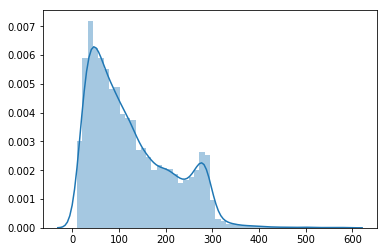

In [ ]:
import seaborn as sns
sentence_lengths = [len(sentence) for sentence in train_X]
sns.distplot(sentence_lengths);
max_length = 320

In [ ]:
import tensorflow as tf
import tensorflow_datasets
from transformers import *

# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# create list of input examples so we can get the data in the correct format for BERT
import json
import copy
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

input_examples = []

for ix, sentence in enumerate(train_X):
  #We replace the many instances of '@USER' in the tweets with a typical name e.g. 'Adam'
  #so that the pre-trained embedder can provide a more appropriate embedding for this word
  sentence = sentence.replace("@USER", "Adam")
  example = InputExample(guid=ix, text_a=sentence, label=train_y[ix])
  input_examples.append(example)

examples = glue_convert_examples_to_features(input_examples, tokenizer, max_length=max_length, label_list=list(set(train_y)), output_mode = "classification") # task='mrpc')

def gen():
    for ex in examples:
        yield  ({'input_ids': ex.input_ids,
                  'attention_mask': ex.attention_mask,
                  'token_type_ids': ex.token_type_ids},
                ex.label)

full_dataset = tf.data.Dataset.from_generator(gen,
    ({'input_ids': tf.int32,
      'attention_mask': tf.int32,
      'token_type_ids': tf.int32},
      tf.int64),
    ({'input_ids': tf.TensorShape([None]),
      'attention_mask': tf.TensorShape([None]),
      'token_type_ids': tf.TensorShape([None])},
      tf.TensorShape([])))


100%|██████████| 213450/213450 [00:00<00:00, 5479973.24B/s]


In [ ]:
#We create an F1 callback because the competition is judged on our F1 score
from keras.callbacks import Callback
from sklearn.metrics import f1_score
                                          
class F1Evaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        predictions = np.array([])
        truth = np.array([])
        for _ in range(28):
          x, y = next(iter(val_dataset))
          y_pred = self.model.predict(x) > 0
          y_pred = y_pred.argmax(axis=1)
          y = y.numpy()
          predictions = np.append(predictions, y_pred)
          truth = np.append(truth, y)
        score = f1_score(truth, predictions)
        print("\n F1-score - epoch: %d - score: %.6f \n" % (epoch+1, score))

Using TensorFlow backend.


#2. Modelling

Now we load a pre-trained BERT model with a classification layer appended to the end of the model and train it for 2 epochs

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased')
batch_size = 16
val_size = 1000

full_dataset = full_dataset.shuffle(len(train_X))
val_dataset = full_dataset.take(val_size).batch(batch_size)
train_dataset = full_dataset.skip(val_size).batch(batch_size)

train_steps_per_epoch = int((len(train_X) - val_size) / batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
f1 = F1Evaluation()

model.fit(train_dataset, epochs=2, steps_per_epoch=train_steps_per_epoch,  
          validation_data=val_dataset, validation_steps=5, 
          callbacks=[f1]) 


Train for 765 steps, validate for 5 steps
764/765 [============================>.] - ETA: 2s - loss: 0.3388 - accuracy: 0.8591
 F1-score - epoch: 1 - score: 0.900344 

765/765 [==============================] - 1678s 2s/step - loss: 0.3388 - accuracy: 0.8592 - val_loss: 0.2484 - val_accuracy: 0.9000


**Our validation set F1 after only 2 epochs is 0.9. A similar score on the test set would have been enough to win the competition.**